# Has our simulated Markov Chain converged to the stationary distribution?

From our theory of Markov chains, we expect our chains to eventually converge to the stationary distribution, which is also our target distribution.

It is important to check whether we have a valid sample, otherwise any analysis will be totally flawed. 

There are several tests we can perform, some are visual and some are quantitative. These tests are designed to spot problems with our samples, but they are unable to prove that we have the correct distribution; they can only provide evidence that the sample seems reasonable.

In [1]:
import logging, sys
logging.disable(sys.maxsize)

In [2]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.integrate import quad

In [3]:
%%capture
obs = [-4.]
niter = 5000
nchains = 4
seed = 123

with pm.Model() as model:
    m = pm.Uniform('m', lower=0., upper=10.)
    likelihood = pm.Normal('y_obs', mu=m, sigma=2., observed=obs)
    step_0 = pm.Metropolis(S=np.array([.01]), tune_interval=niter)
    step_1 = pm.Metropolis(S=np.array([10]), tune_interval=niter)
    step_2 = pm.Metropolis(S=np.array([2.5]), tune_interval=niter)
    trace_0 = pm.sample(niter, step=step_0, tune=0, chains=nchains, random_seed=seed)
    trace_1 = pm.sample(niter, step=step_1, tune=0, chains=nchains, random_seed=seed)
    trace_2 = pm.sample(niter, step=step_2, tune=0, chains=nchains, random_seed=seed)

# Burn-in
The term *burn-in* describes the practice of throwing away some iterations at the beginning of the MCMC. This is done to cancel out the dependence of the chains on the starting values.

Here we show an example of 3 chains with different starting values.

In [4]:
%%capture
with model:
    step_new = pm.Metropolis(S=np.array([.2]))
    ex0 = pm.sample(niter, step=step_new, tune=0, chains=1, initvals={'m': 9}, random_seed=123)
    ex1 = pm.sample(niter, step=step_new, tune=0, chains=1, initvals={'m': 6}, random_seed=456)
    ex2 = pm.sample(niter, step=step_new, tune=0, chains=1, initvals={'m': 3}, random_seed=789)

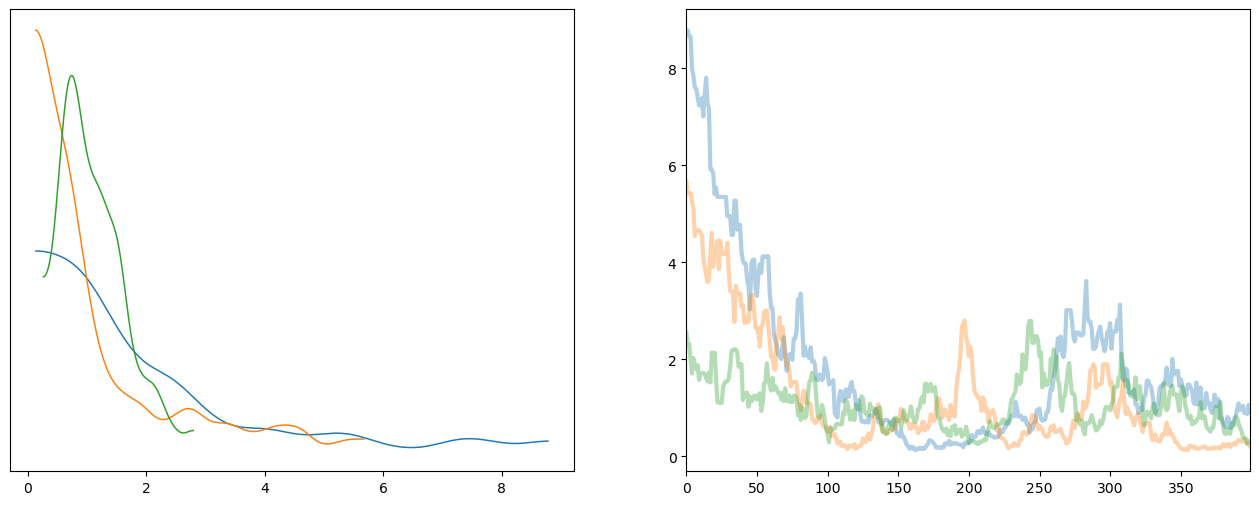

In [5]:
niter_plot = 400
tr_data = np.array([ex0.posterior.m[:,:niter_plot], ex1.posterior.m[:,:niter_plot], ex2.posterior.m[:,:niter_plot]])
az.plot_trace(tr_data[:,0,:], compact=0, trace_kwargs={'linewidth': 3}, 
              labeller=az.labels.MapLabeller(var_name_map={"x": ''}), figsize=(16, 6))
pass

In [6]:
%%capture
nburn = 2000
with model:
    trace_0 = pm.sample(niter, step=step_0, tune=nburn, chains=nchains, random_seed=seed)
    trace_1 = pm.sample(niter, step=step_1, tune=nburn, chains=nchains, random_seed=seed)
    trace_2 = pm.sample(niter, step=step_2, tune=nburn, chains=nchains, random_seed=seed)

# Traceplot
A traceplot shows the history of a parameter value across iterations of the chain. It's easy to spot from the traceplot whether our chains adequately explored the parameter space or not.

We highlight with a red dashed line the end of the burn-in period.

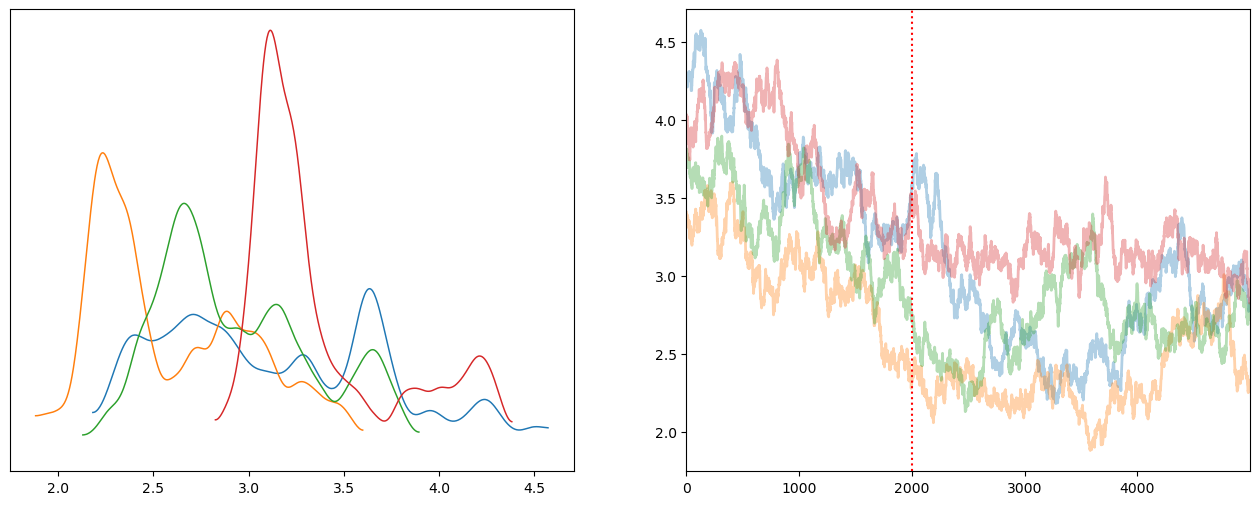

In [7]:
az.plot_trace(trace_0, var_names=['m'], figsize=(16, 6), trace_kwargs={'linewidth': 2}, compact=0, 
             labeller=az.labels.MapLabeller(var_name_map={"m": ''}))
plt.axvline(nburn, color='r', linestyle=':')
pass

Model 0

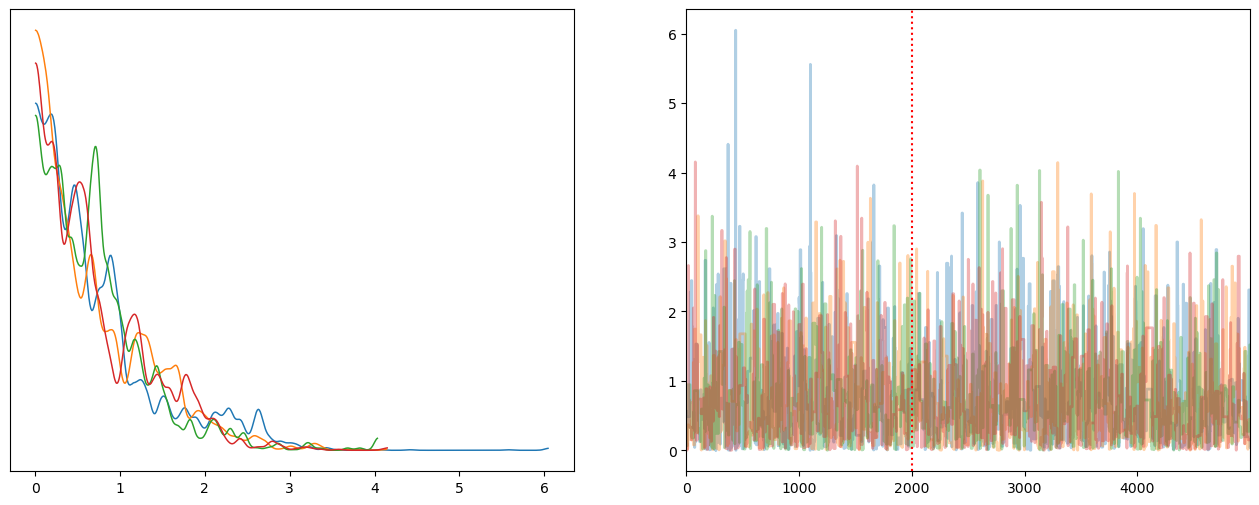

In [8]:
az.plot_trace(trace_1, var_names=['m'], figsize=(16, 6), trace_kwargs={'linewidth': 2}, compact=0, 
              labeller=az.labels.MapLabeller(var_name_map={"m": ''}))#, textsize=20)
plt.axvline(nburn, color='r', linestyle=':')
pass

Model 1

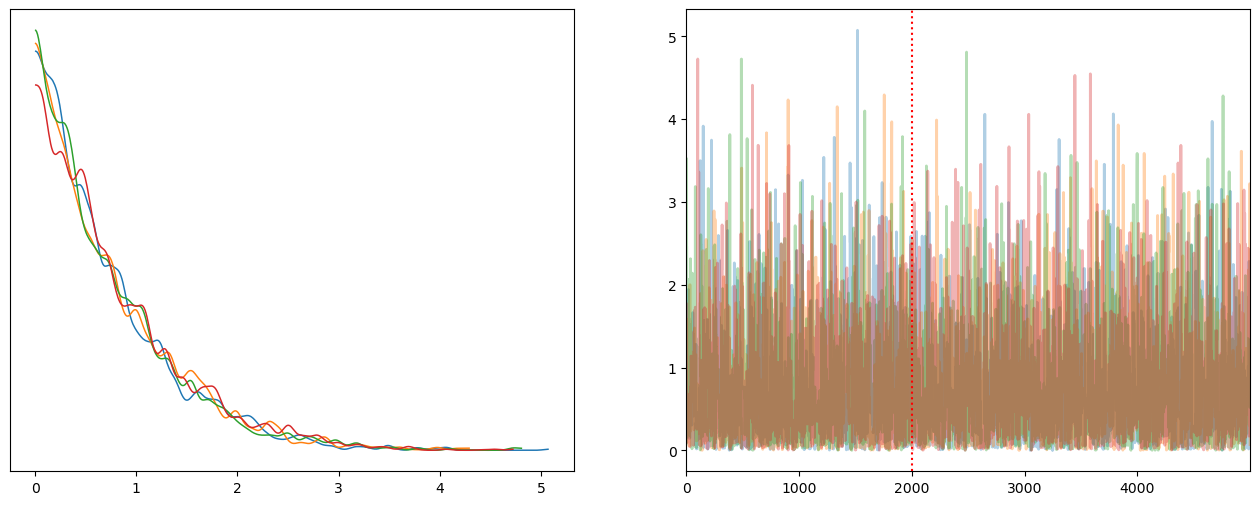

In [9]:
az.plot_trace(trace_2, var_names=['m'], figsize=(16, 6), trace_kwargs={'linewidth': 2}, compact=0, 
              labeller=az.labels.MapLabeller(var_name_map={"m": ''}))
plt.axvline(nburn, color='r', linestyle=':')
pass

Model 2

Let us have a closer look at a small portion of 100 iterations from the traceplot. This visualization allows us to spot more adequately the behaviour of each chain.

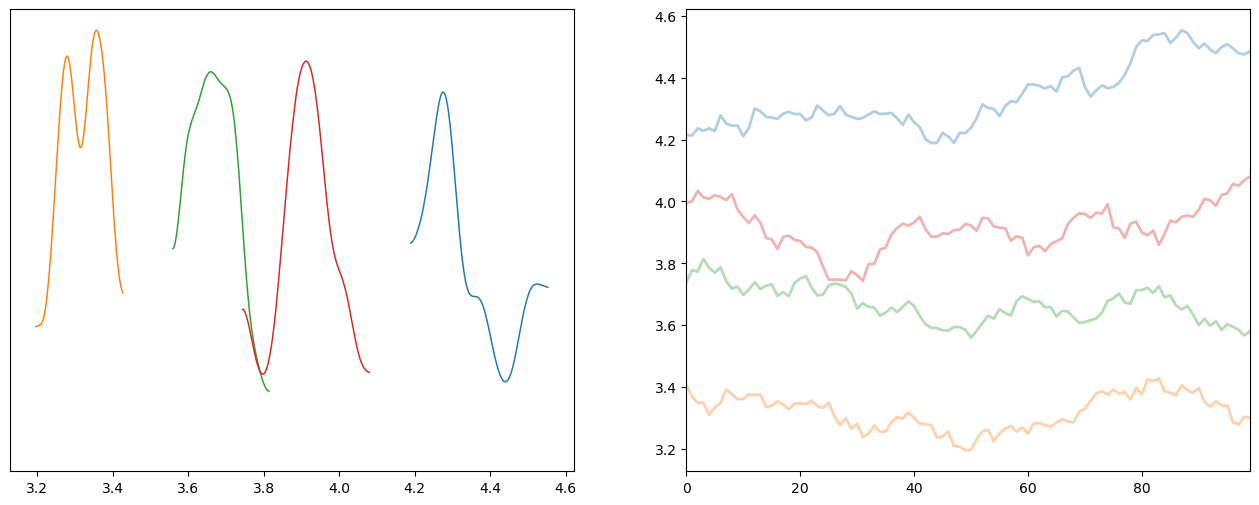

In [10]:
pm.plot_trace(trace_0.posterior.m[:,:100], var_names=['m'], figsize=(16, 6), trace_kwargs={'linewidth': 2}, 
              compact=0, labeller=az.labels.MapLabeller(var_name_map={"m": ''}))
pass

Model 0

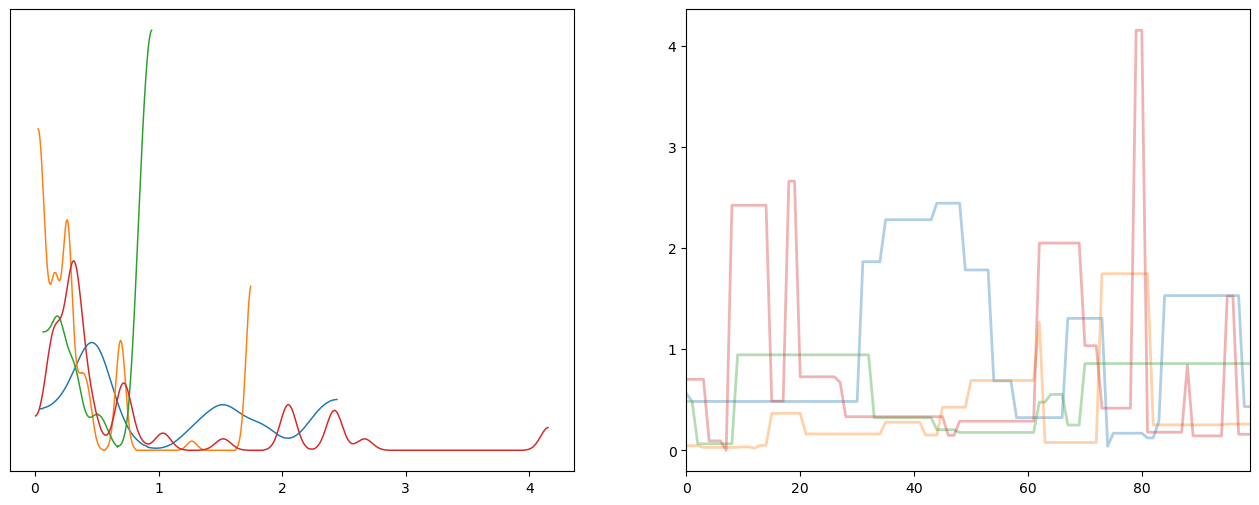

In [11]:
pm.plot_trace(trace_1.posterior.m[:,:100], var_names=['m'], figsize=(16, 6), trace_kwargs={'linewidth': 2},
              compact=0, labeller=az.labels.MapLabeller(var_name_map={"m": ''}))
pass

Model 1

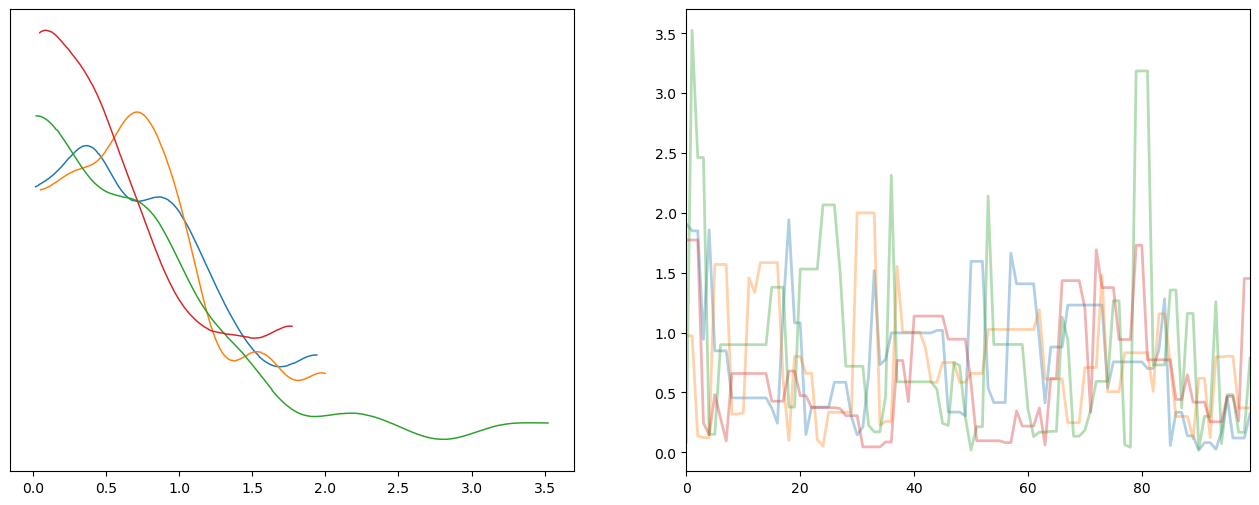

In [12]:
pm.plot_trace(trace_2.posterior.m[:,:100], var_names=['m'], figsize=(16, 6), trace_kwargs={'linewidth': 2},
              compact=0, labeller=az.labels.MapLabeller(var_name_map={"m": ''}))
pass

Model 2

# Posterior distribution
In this particular example, we can easily check whether the MCMC did or did not converge to his stationary distribution, which is our target posterior distribution. In fact, we can compute the real distribution analytically and overplot it to the simulated data.

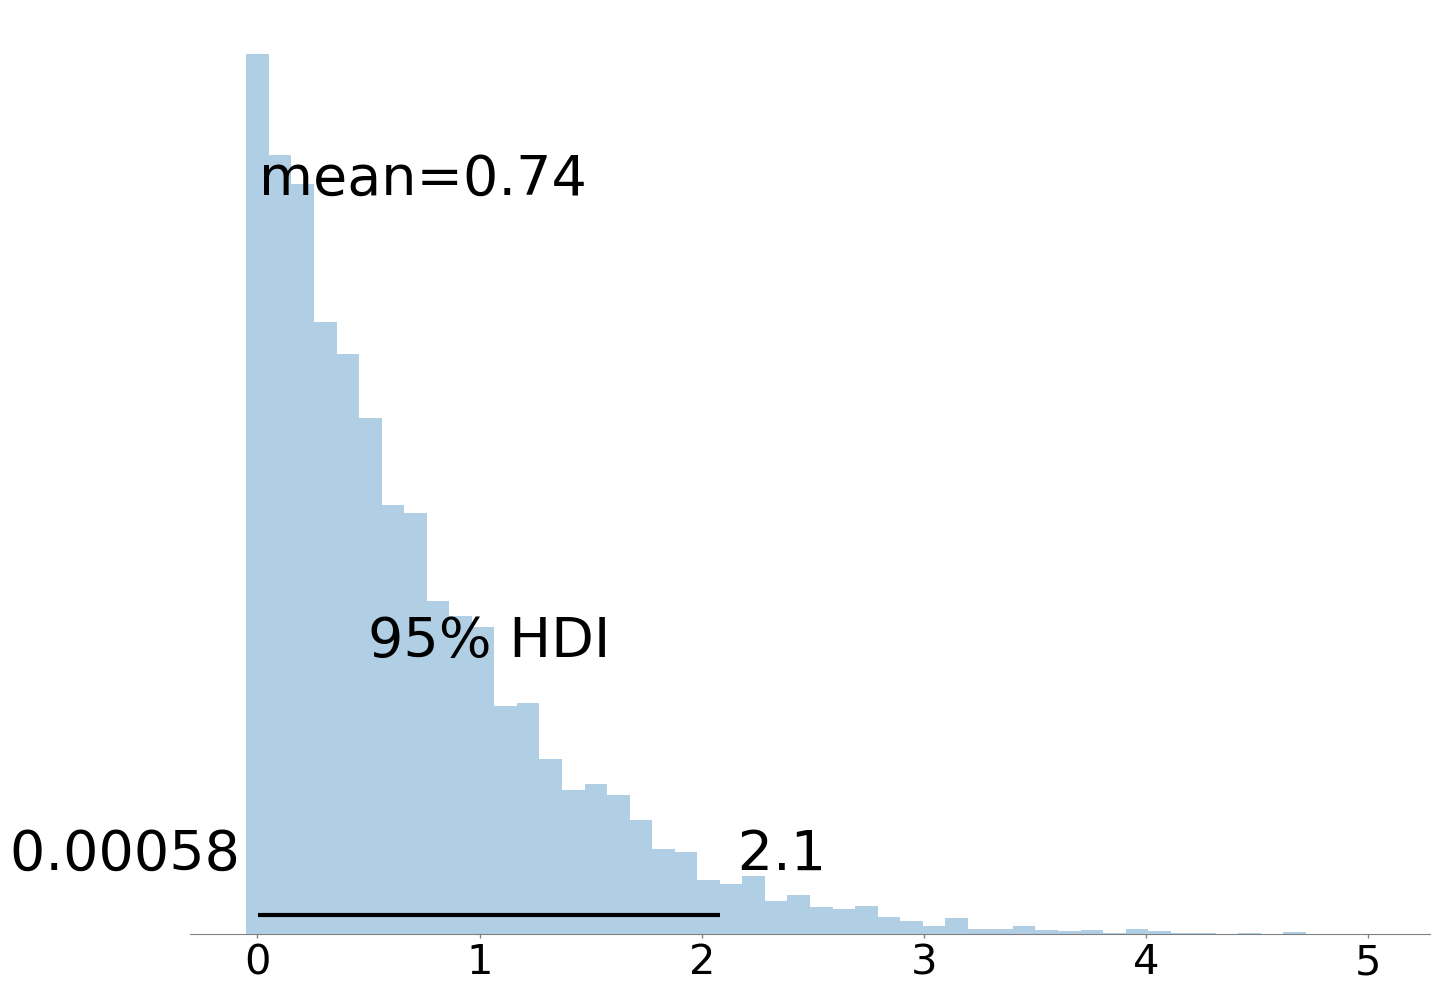

In [13]:
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['axes.labelsize'] = 40
az.plot_posterior(trace_2, var_names=['m'], kind='hist', density=True, hdi_prob=.95, 
                 labeller=az.labels.MapLabeller(var_name_map={"m": ''}), bins=50)
pass

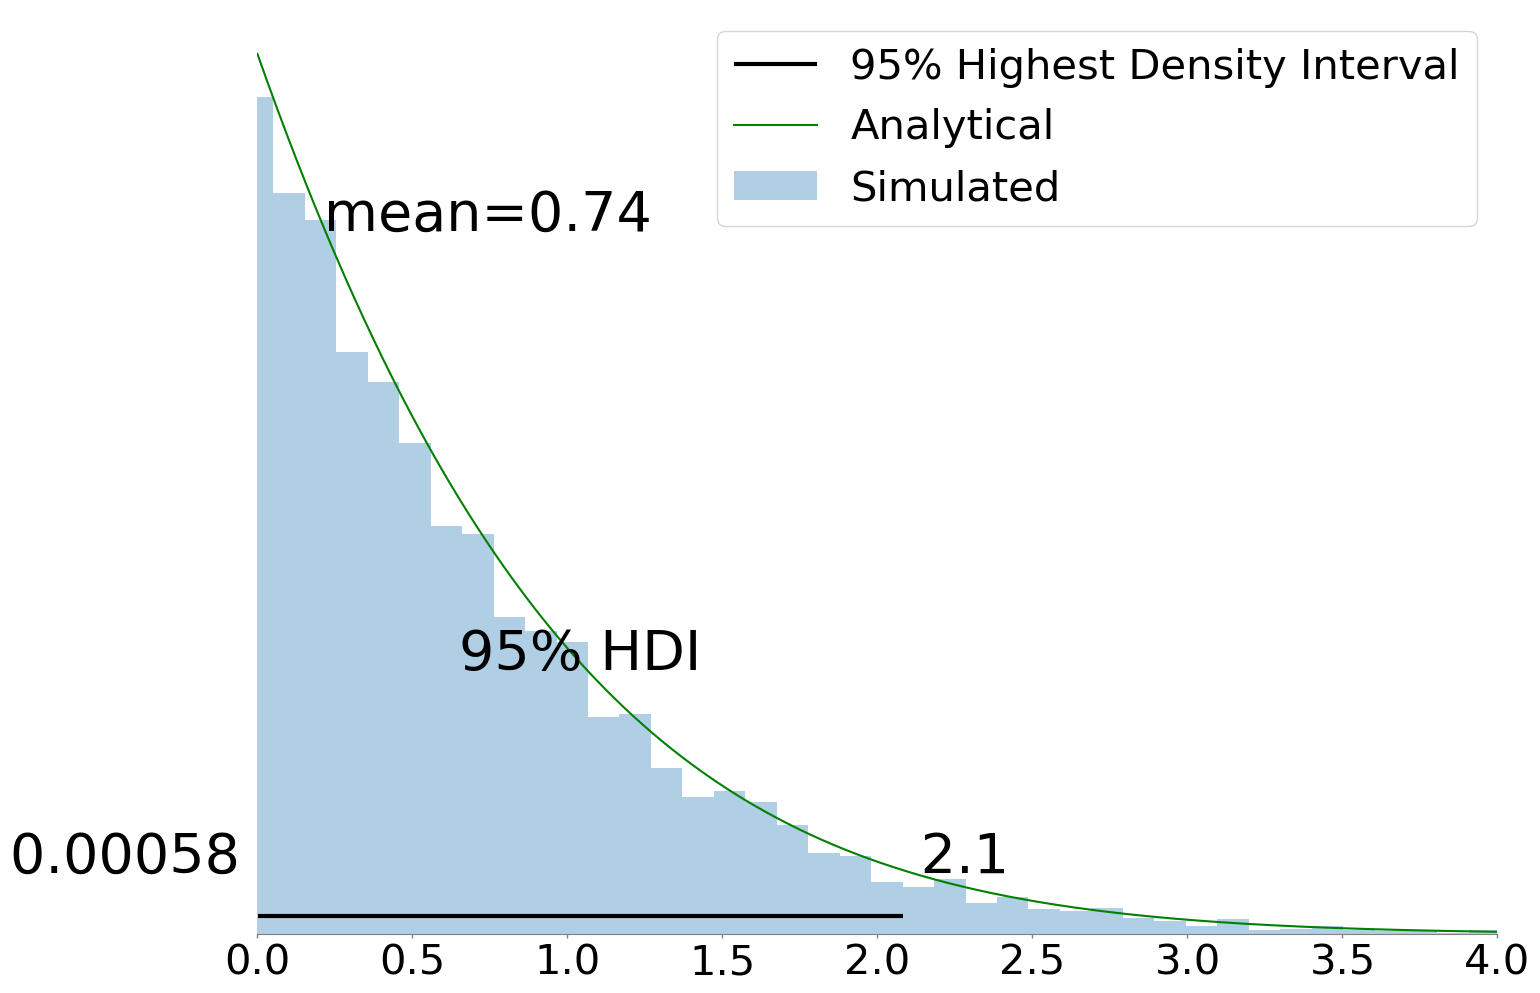

In [14]:
az.plot_posterior(trace_2, var_names=['m'], kind='hist', density=True, hdi_prob=.95, 
                 labeller=az.labels.MapLabeller(var_name_map={"m": ''}), bins=50)
def prior(x): return st.uniform.pdf(x, 0., 10.) 
def likelihood(x): return st.norm.pdf(x, -4., 2.)
def numerator(x): return prior(x)*likelihood(x)
def posterior(x): return numerator(x)/quad(numerator, 0., 10.)[0]
x = np.arange(0., 10., .001)
plt.plot(x, posterior(x), 'g')
plt.xlim(0, 4)
plt.legend(('95% Highest Density Interval', 'Analytical', 'Simulated'), prop={'size': 30})
pass

# Summary statistics
Useful summary statistics on the posterior distribution can be computed from the simulated data, such as the posterior mean, the posterior standard deviation and quantiles for the distribution. The 95% Highest Posterior Density (HPD) interval includes the 95% most probable values from the posterior distribution.

Model 0

In [15]:
pm.summary(trace_0, kind='stats', hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%
m,3.022,0.544,2.124,4.191


Model 1

In [16]:
pm.summary(trace_1, kind='stats', hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%
m,0.735,0.649,0.0,2.06


Model 2

In [17]:
pm.summary(trace_2, kind='stats', hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%
m,0.744,0.671,0.001,2.084


# Forest plot
The forest plot help us in visualizing these summary statistics.

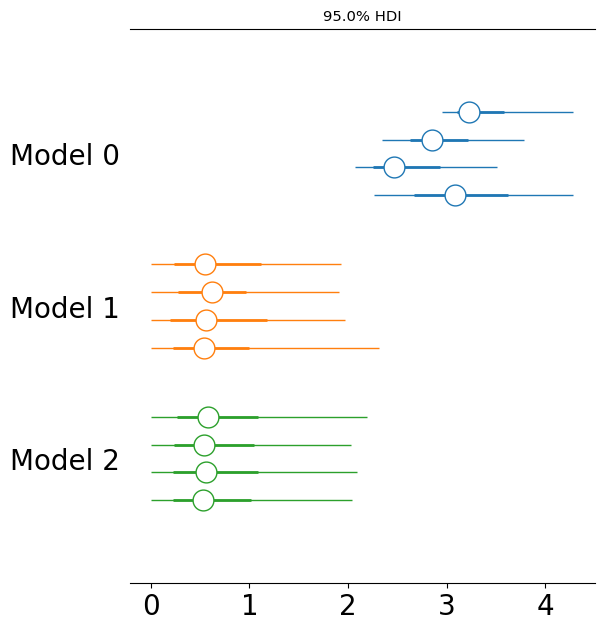

In [18]:
az.plot_forest([trace_0, trace_1, trace_2], hdi_prob=.95, textsize=20, markersize=20, 
               labeller=az.labels.MapLabeller(var_name_map={"m": ''}), legend=0)
pass

# Acceptance rate
The acceptance rate is given by the fraction of iterations where the Markov chain moved from the previous state to a new one according to the proposal distribution.

\begin{equation*}
acceptance\>rate=\frac{\#\>accepted\>candidate\>samples}{\#\>iterations}
\end{equation*}

Optimal values for the acceptance rate vary depending on the step method adopted, e.g. we usually are looking for an acceptance rate between 0.2 and 0.5 when we are working with a random walk Metropolis-Hastings algorithm. 
Too low acceptance rate means that the chain remains stuck at a single value for quite a long time and thus we would need a higher candidate standard deviation. On the other hand, too high acceptance rate means that the candidate standard deviation is extremely low and the chain wanders.

In [19]:
print('Model 0: acc_rate = '+str(np.round(trace_0.sample_stats.accepted[:,nburn:].mean().data, 3)))
print('Model 1: acc_rate = '+str(np.round(trace_1.sample_stats.accepted[:,nburn:].mean().data, 3)))
print('Model 2: acc_rate = '+str(np.round(trace_2.sample_stats.accepted[:,nburn:].mean().data, 3)))

Model 0: acc_rate = 0.99
Model 1: acc_rate = 0.146
Model 2: acc_rate = 0.472


# Autocorrelation plot
When dealing with a Markov Chain, *i.e.* a sequence of random variables, we come into contact with the concept of autocorrelation.
The autocorrelation function (ACF) between two variables $X_t$ and $X_{t+h}$ is defined as:

\begin{equation*}
    ACF\left(X_t, X_{t+h}\right)=\frac{Cov\left(X_t, X_{t+h}\right)}{\sqrt{Var\left(X_t\right)\times Var\left(X_{t+h}\right)}}
\end{equation*}

where the covariance $Cov\left(X_t, X_{t+h}\right)=\mathbf{E}\left[\left(X_t-\bar{X}_t\right)\left(X_{t+h}-\bar{X}_{t+h}\right)\right]$ is a measure of the joint variability of two random variables.

Correlation is often more useful than covariance because it is standardized to be between −1 and 1, which makes it interpretable as a standard measure of linear relationship between any two variables.

If the sequence is stationary, so that the joint distribution does not change with shifts, the autocorrelation for two variables $X_t$ and $X_{t+h}$ depends on the distance $h$ between them, called lag.

We would expect the $h$-th lag autocorrelation to be smaller as $h$ increases. If autocorrelation is still relatively high for higher values of $h$, this indicates high degree of correlation between our draws.

Autocorrelation makes a great difference in how much information we get out of our Markov chains.

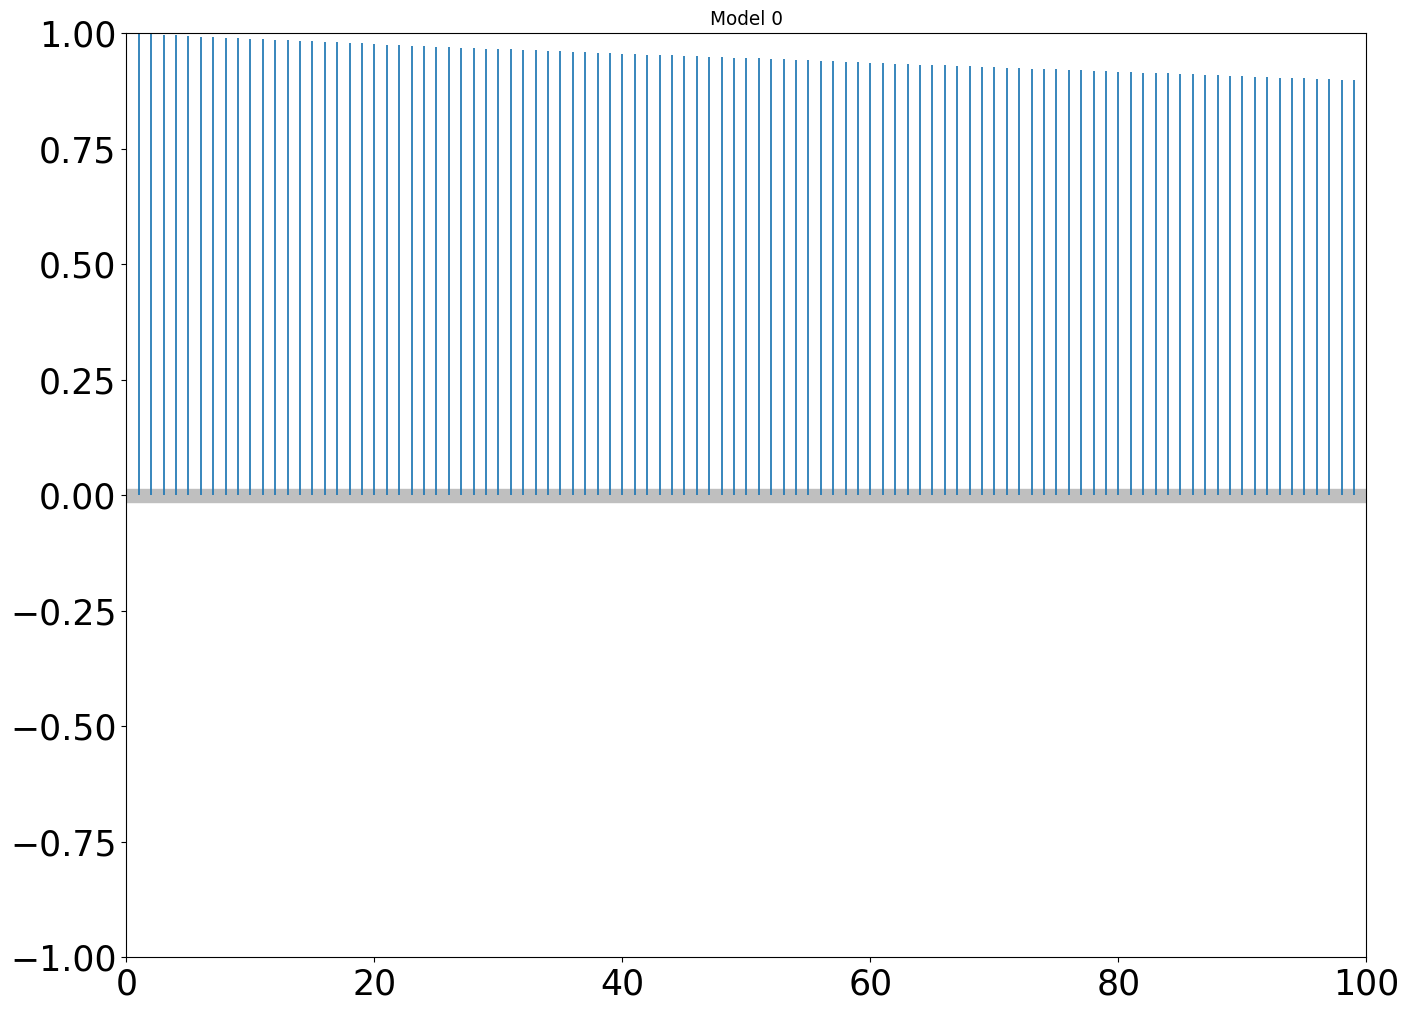

In [20]:
az.plot_autocorr(trace_0, var_names=['m'], combined=True, textsize=25, 
                 labeller=az.labels.MapLabeller(var_name_map={"m": 'Model 0'}))
pass

Model 0

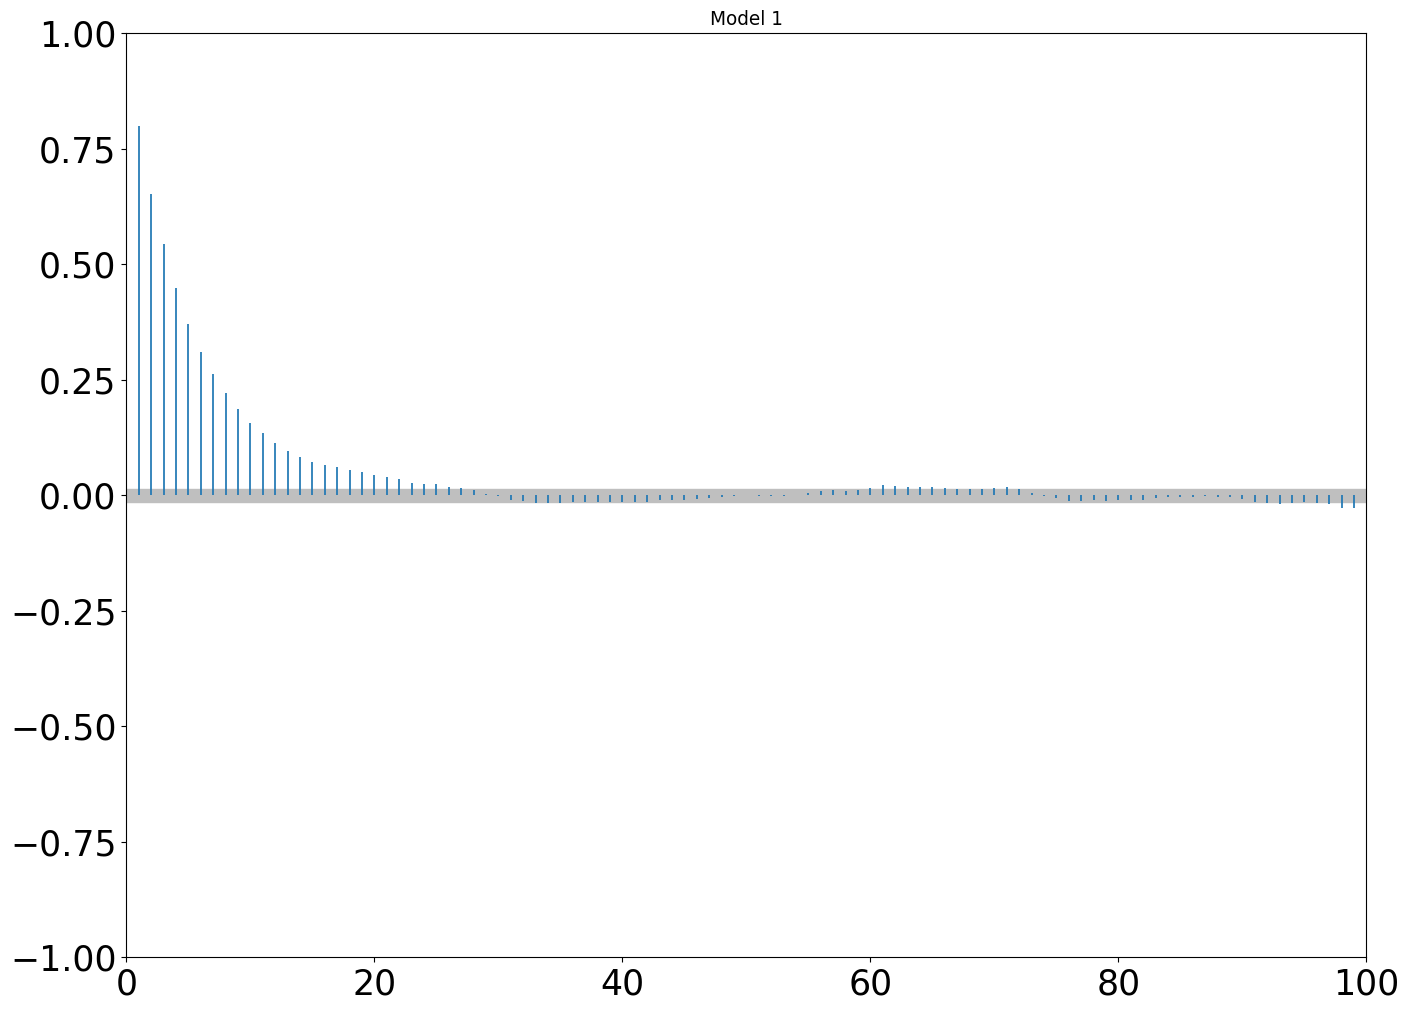

In [21]:
az.plot_autocorr(trace_1, var_names=['m'], combined=True, textsize=25, 
                 labeller=az.labels.MapLabeller(var_name_map={"m": 'Model 1'}))
pass

Model 1

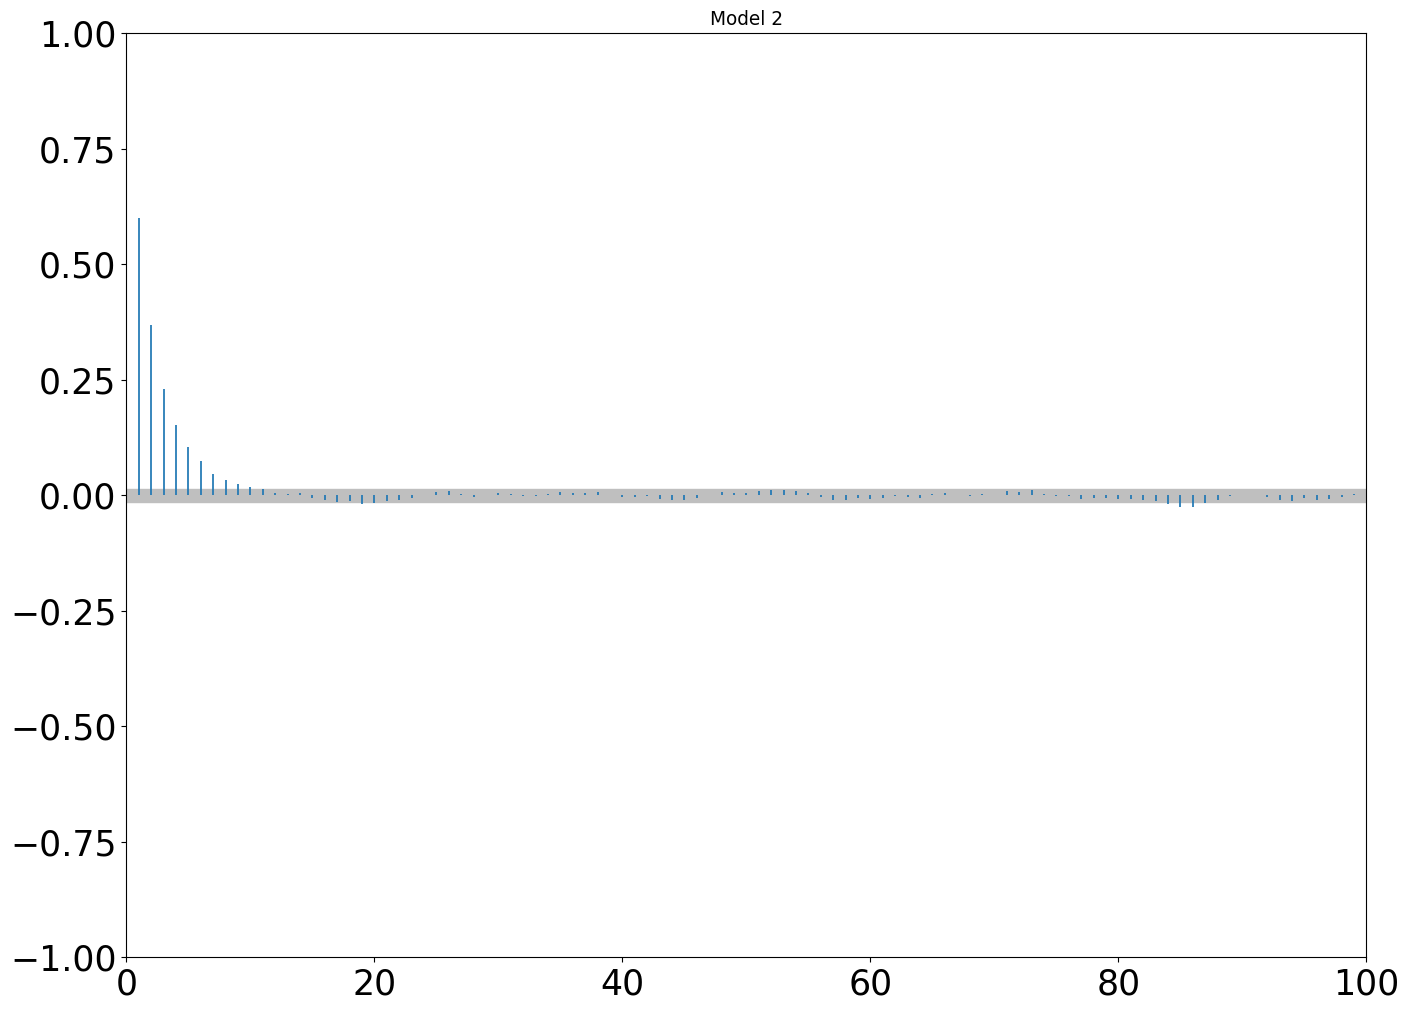

In [22]:
az.plot_autocorr(trace_2, var_names=['m'], combined=True, textsize=25, 
                 labeller=az.labels.MapLabeller(var_name_map={"m": 'Model 2'}))
pass

Model 2

# Effective sample size
The Monte Carlo effective sample size tells us how many independent samples from the stationary distribution we would need to get equivalent information from the Markov Chain. It is defined as following:

\begin{equation*}
\hat{n}_{eff}=\frac{mn}{\hat{\tau}}=\frac{mn}{-1 + 2 \sum_{t'=0}^K \hat{P}_{t'}}
\end{equation*}

where 
- $m$ is the number of chains, 
- $n$ is the number of iterations per chain,
- $K$ is the last integer for which $\hat{P}_{K}$ is still positive
- $\hat{P}_{t'} = \hat{\rho}_{2t'} + \hat{\rho}_{2t'+1}$, where $\hat{\rho}_t$ is the estimated autocorrelation at lag $t$.

In [23]:
print('Model 0: ess = %.1f' % az.ess(trace_0)['m'].data)
print('Model 1: ess = %.1f' % az.ess(trace_1)['m'].data)
print('Model 2: ess = %.1f' % az.ess(trace_2)['m'].data)

Model 0: ess = 6.1
Model 1: ess = 1742.0
Model 2: ess = 3878.7


# Gelman-Rubin diagnostic
The Gelman-Rubin diagnostic uses an analysis of variance approach to assessing convergence. It compares the variance between multiple chains, B, to the variance within each chain, W, assessing whether they are different enough to worry about convergence. It is defined as:

\begin{equation*}
\hat{R}=\sqrt{\frac{\hat{V}(\theta|data)}{W}}=\sqrt{\frac{1}{W}\left[\left(1-\frac{1}{n}\right)W+\frac{1}{n}B\right]},
\end{equation*}
where:
- $\hat{V}(\theta|data)$ is the posterior variance estimate, derived as a weighted sum of W and B,
- $n$ is the number of iterations in each chain.

$\hat{R}$ is referred to as the potential scale reduction factor and it converges to unity when each of the traces is a sample from the target posterior. Values greater than one indicate that one or more chains have not yet converged.

In [24]:
print('Model 0: R = %f' % az.rhat(trace_0).m.data)
print('Model 1: R = %f' % az.rhat(trace_1).m.data)
print('Model 2: R = %f' % az.rhat(trace_2).m.data)

Model 0: R = 1.717654
Model 1: R = 1.004822
Model 2: R = 1.000858


# Geweke diagnostic
The Geweke diagnostics aims to compare an early portion of the chain (usually 10%) with a late portion (usually 50%) to verify that the distributions are similar enough. It is a test on the burn-in period: if the two means do not significantly differ, we can consider the early portion as burn-in, otherwise we need to burn more iterations from the chain.

The diagnostic consists of a two-sample T-test for the difference in means:

\begin{equation*}
    T=\frac{\bar{X}_1-\bar{X}_2}{\sqrt{\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}}}
\end{equation*}

With an adequately wide sample size, the T distribution can be approximated using the standard normal Z.


In [25]:
def geweke(ary, first=0.1, last=0.5, intervals=20):
    # Filter out invalid intervals
    for interval in (first, last):
        if interval <= 0 or interval >= 1:
            raise ValueError("Invalid intervals for Geweke convergence analysis", (first, last))
    if first + last >= 1:
        raise ValueError("Invalid intervals for Geweke convergence analysis", (first, last))
    # Initialize list of z-scores
    zscores = []
    # Last index value
    end = len(ary) - 1
    # Start intervals going up to the <last>% of the chain
    last_start_idx = (1 - last) * end
    # Calculate starting indices
    start_indices = np.linspace(0, last_start_idx, num=intervals, endpoint=True, dtype=int)
    # Loop over start indices
    for start in start_indices:
        # Calculate slices
        first_slice = ary[start : start + int(first * (end - start))]
        last_slice = ary[int(end - last * (end - start)) :]
        z_score = first_slice.mean() - last_slice.mean()
        z_score /= np.sqrt(first_slice.var() + last_slice.var())
        zscores.append([start, z_score])
    return np.array(zscores)

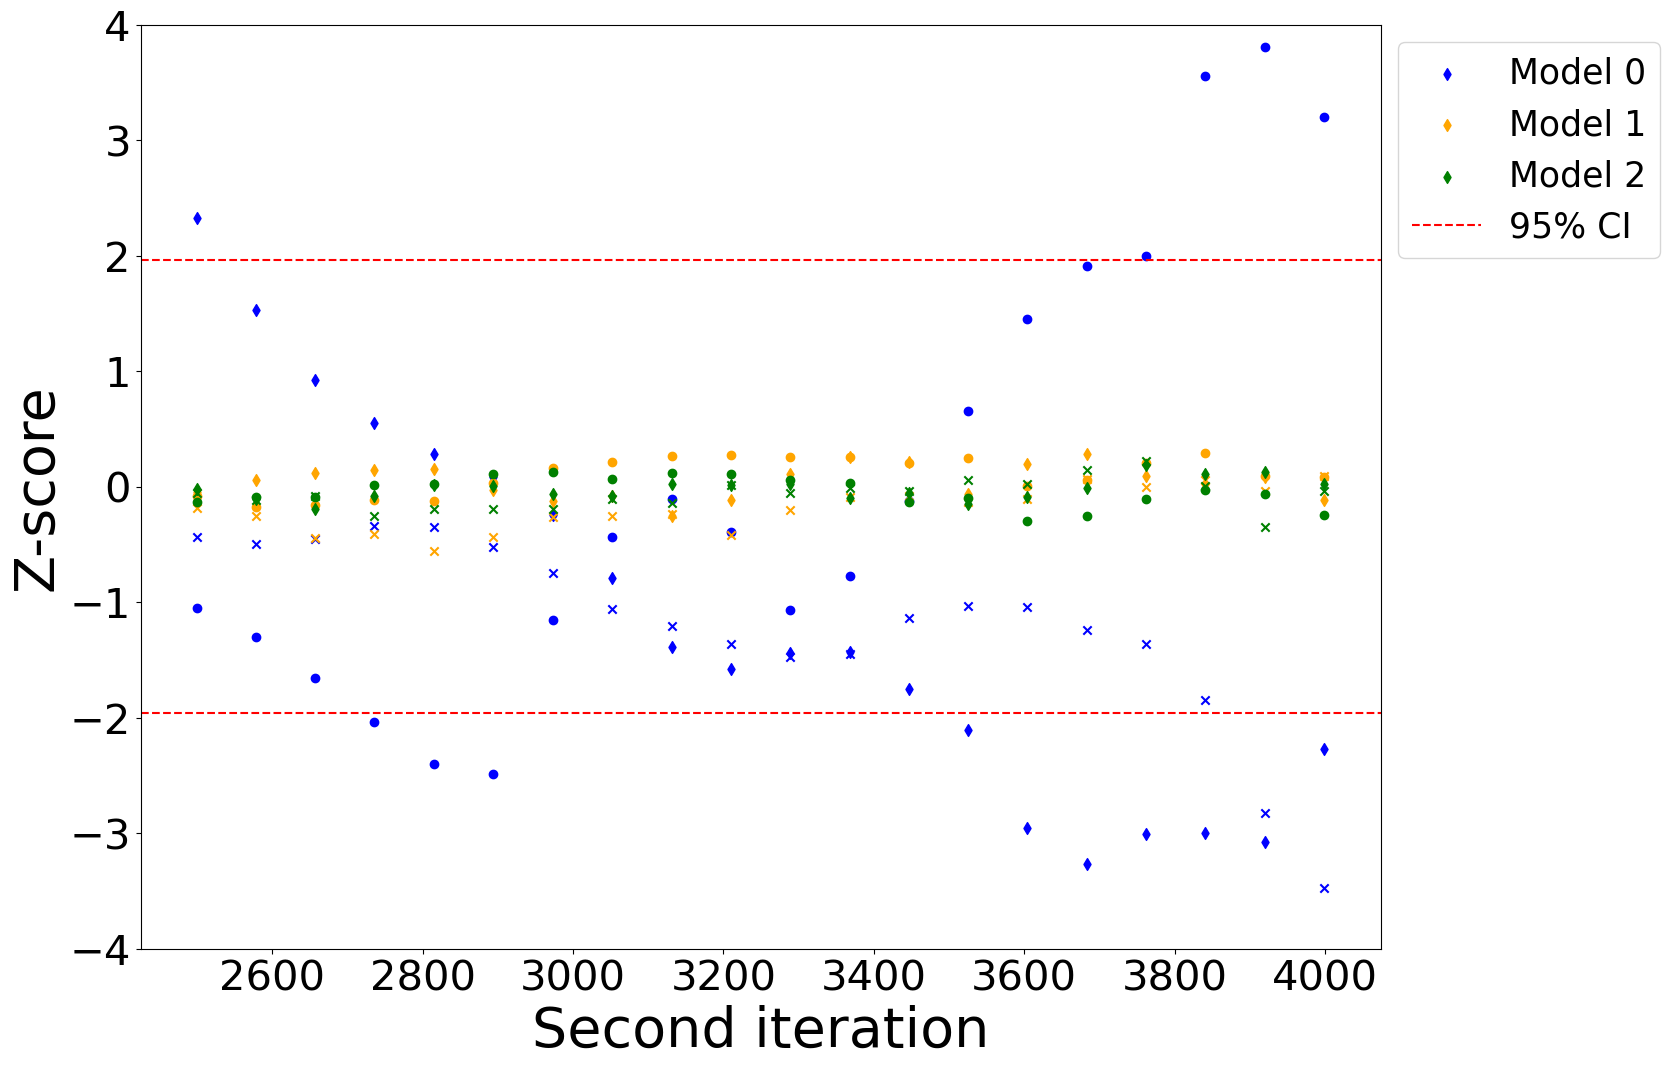

In [26]:
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['axes.labelsize'] = 40
gew_0 = [geweke(trace_0.posterior.m.data[i,nburn:].flatten(), first=.1, last=.5) for i in range(3)]
dots = ['d', 'x', 'o']
[plt.scatter(niter/2+gew_0[i][:,0], gew_0[i][:,1], marker=dots[i], color='blue', 
             label='Model 0' if i==0 else '_nolegend_') for i in range(3)]
gew_1 = [geweke(trace_1.posterior.m.data[i,nburn:].flatten(), first=.1, last=.5) for i in range(3)]
[plt.scatter(niter/2+gew_1[i][:,0], gew_1[i][:,1], marker=dots[i], color='orange',
             label='Model 1' if i==0 else '_nolegend_') for i in range(3)]
gew_2 = [geweke(trace_2.posterior.m.data[i,nburn:].flatten(), first=.1, last=.5) for i in range(3)]
[plt.scatter(niter/2+gew_2[i][:,0], gew_2[i][:,1], marker=dots[i], color='green',
             label='Model 2' if i==0 else '_nolegend_') for i in range(3)]
plt.xlabel('Second iteration')
plt.ylabel('Z-score')
plt.ylim(-4, 4)
plt.axhline(-st.norm.ppf(.975), linestyle='--', color='red', label='95% CI')
plt.axhline(st.norm.ppf(.975), linestyle='--', color='red', label='_nolegend_')
plt.legend(bbox_to_anchor=(1,1), prop={'size': 25})
pass

# Dulcis in fundo

In [27]:
pm.summary(trace_0, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,3.022,0.544,2.124,4.191,0.22,0.163,6.0,17.0,1.72


In [28]:
pm.summary(trace_1, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,0.735,0.649,0.0,2.06,0.015,0.011,1742.0,1810.0,1.0


In [29]:
pm.summary(trace_2, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,0.744,0.671,0.001,2.084,0.01,0.007,3879.0,4173.0,1.0


In [30]:
%%capture
logging.disable(logging.NOTSET)
with model:
    trace_0 = pm.sample(niter, step=step_0, tune=nburn, chains=nchains, random_seed=seed)
    trace_1 = pm.sample(niter, step=step_1, tune=nburn, chains=nchains, random_seed=seed)
    trace_2 = pm.sample(niter, step=step_2, tune=nburn, chains=nchains, random_seed=seed)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [m]
Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 4 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [m]
Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 4 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [m]
Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 4 seconds.


In [31]:
%%capture
with model:
    step_0 = pm.Metropolis(S=np.array([.01]))#, tune_interval=niter)
    step_1 = pm.Metropolis(S=np.array([10]))#, tune_interval=niter)
    step_2 = pm.Metropolis(S=np.array([2.5]))#, tune_interval=niter)
    trace_0 = pm.sample(niter, step=step_0, tune=nburn, chains=nchains, random_seed=seed)
    trace_1 = pm.sample(niter, step=step_1, tune=nburn, chains=nchains, random_seed=seed)
    trace_2 = pm.sample(niter, step=step_2, tune=nburn, chains=nchains, random_seed=seed)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [m]
Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 4 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [m]
Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 4 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [m]
Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 4 seconds.


In [32]:
pm.summary(trace_0, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,0.737,0.664,0.0,2.032,0.01,0.007,4039.0,4227.0,1.0


In [33]:
pm.summary(trace_1, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,0.751,0.687,0.001,2.104,0.012,0.009,2861.0,3522.0,1.0


In [34]:
pm.summary(trace_2, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,0.742,0.668,0.0,2.098,0.01,0.007,3849.0,4122.0,1.0


# References
- https://docs.pymc.io/notebooks/api_quickstart.html
- https://docs.pymc.io/api/plots.html
- https://docs.pymc.io/api/diagnostics.html
- https://www2.math.su.se/matstat/reports/master/2011/rep2/report.pdf
- http://patricklam.org/teaching/convergence_print.pdf
-  Geweke J. Evaluating the accuracy of sampling based approaches to the calculation of posterior moments. _Bayesian Statistics 4, pp. 169-193_, 1992.

In [35]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="October 2023"></form>''')